# Access data from ASReview file

<div class="alert alert-warning">

The API is still under development and can change at any time without warning. 

</div>

Data generated using ASReview LAB is stored in an ASReview project file. Via the ASReview Python API, there are two ways to access the data in the ASReview (extension `.asreview`) file: Via the [asreview.Project](reference/asreview.rst#asreview.Project) API and the [asreview.SQLiteState](reference/asreview.rst#asreview.SQLiteState) API. The project API is for retrieving general project settings, the imported dataset, the feature matrix, etc. The state API retrieves data related directly to the reviewing process, such as the labels, the time of labeling, and the classifier used. 

The ASReview Python API can be used for project files obtained reviews and simulations.




## Example Data
To illustrate the ASReview Python API, the benchmark dataset `van_de_Schoot_2017` is used. The project file `example.asreview` can be obtained by running the following command:

In [ ]:
%%bash

asreview simulate synergy:van_de_Schoot_2018 -o example.asreview

## Python imports

Import the `asreview` module as `asr`.

In [1]:
from pathlib import Path

import asreview as asr

## Project API

The ASReview project file is a zipped folder with the extension `.asreview`. This makes inspection of it's contents straightforward. The `asreview` Python package offers an API to open a project file directly as an [asreview.Project](reference/asreview.rst#asreview.Project). 

For this example, we will create a temporary folder to unpack the project to:

In [2]:
from tempfile import TemporaryDirectory

tmpdir = TemporaryDirectory()

Open the project with the `load` classmethod of [asreview.Project](reference/asreview.rst#asreview.Project).

In [3]:
project = asr.Project.load("example.asreview", tmpdir.name)

The following files can be found in the folder

In [4]:
tmpdir_path = Path(tmpdir.name)
for path in tmpdir_path.rglob("*"):
    print(path.relative_to(tmpdir_path))

example
example/project.json
example/data_store.db
example/feature_matrices
example/data
example/reviews
example/data/van_de_Schoot_2018.csv
example/reviews/3b7b6c2b3d6f487ba19ffcc4ac8adef5
example/reviews/3b7b6c2b3d6f487ba19ffcc4ac8adef5/results.db



To inspect the project details in `project.json`, use the following code:

In [5]:
project.config

{'version': '2.0b6.dev20+gf283ffd9.d20250505',
 'id': 'example',
 'mode': 'simulate',
 'name': 'van_de_Schoot_2018',
 'created_at_unix': 1746457760,
 'reviews': [{'id': '3b7b6c2b3d6f487ba19ffcc4ac8adef5', 'status': 'finished'}],
 'feature_matrices': [],
 'tags': None,
 'datasets': [{'id': 'van_de_Schoot_2018.csv',
   'name': 'van_de_Schoot_2018.csv'}]}

The imported dataset is located at `data/{dataset_filename}`, and can be inspected using the following code: 

In [6]:
datastore_fp = Path(tmpdir.name) / "example" / "data_store.db"

dataset = asr.DataStore(datastore_fp)
print(f"The dataset contains {len(dataset)} records.")

The dataset contains 4544 records.


In [7]:
dataset.get_df().head()

,dataset_row,dataset_id,duplicate_of,title,abstract,authors,keywords,year,doi,url,included,record_id
0,0,van_de_Schoot_2018.csv,None,Annual Research Review: Resilience and mental ...,Researchers focused on mental health of confli...,[],[],None,https://doi.org/10.1111/jcpp.12053,None,0,0
1,1,van_de_Schoot_2018.csv,None,Profiling the Trauma Related Symptoms of Bosni...,The objective of this study was to profile tra...,[],[],None,https://doi.org/10.1097/00005053-200007000-00004,None,0,1
2,2,van_de_Schoot_2018.csv,None,"Acute panicogenic, anxiogenic and dissociative...",Increased anxiety and panic to inhalation of c...,[],[],None,https://doi.org/10.1016/j.jpsychires.2011.01.009,None,0,2
3,3,van_de_Schoot_2018.csv,None,A Pooled Analysis of Gender and Trauma-Type Ef...,To examine effects of gender and trauma type o...,[],[],None,https://doi.org/10.4088/jcp.v69n1002,None,0,3
4,4,van_de_Schoot_2018.csv,None,Twelve-Month Use of Mental Health Services in ...,Dramatic changes have occurred in mental healt...,[],[],None,https://doi.org/10.1001/archpsyc.62.6.629,None,0,4


## State API

The data stored during the review process can be accessed as a pandas DataFrame using the following code:

In [8]:
with asr.open_state("example.asreview") as state:
    df_results = state.get_results_table()
    print(f"The state contains {len(df_results)} records.")

The state contains 322 records.


The returned `state` instance is of type [asreview.SQLState](reference/asreview.rst#asreview.SQLiteState). Note that the state contains less records than the original dataset. This is because by default the simulation stopped after finding all relevant records.

In [9]:
df_results.tail(10)

,record_id,label,classifier,querier,balancer,feature_extractor,training_set,time,note,tags,user_id
312,1376,0,svm,max,balanced,tfidf,312,1746457765.998829,None,None,<NA>
313,1589,0,svm,max,balanced,tfidf,313,1746457766.009229,None,None,<NA>
314,2368,0,svm,max,balanced,tfidf,314,1746457766.019135,None,None,<NA>
315,1359,0,svm,max,balanced,tfidf,315,1746457766.028713,None,None,<NA>
316,952,0,svm,max,balanced,tfidf,316,1746457766.038262,None,None,<NA>
317,1754,0,svm,max,balanced,tfidf,317,1746457766.04837,None,None,<NA>
318,1985,0,svm,max,balanced,tfidf,318,1746457766.05749,None,None,<NA>
319,1196,0,svm,max,balanced,tfidf,319,1746457766.06699,None,None,<NA>
320,1008,0,svm,max,balanced,tfidf,320,1746457766.076556,None,None,<NA>
321,3442,1,svm,max,balanced,tfidf,321,1746457766.086036,None,None,<NA>


You can merge the information from the state file with the original dataset. 

In [10]:
dataset_with_results = df_results.reset_index(names="labeling_order").join(
    dataset.get_df().set_index("record_id")
)
dataset_with_results.head()

,labeling_order,record_id,label,classifier,querier,balancer,feature_extractor,training_set,time,note,...,dataset_id,duplicate_of,title,abstract,authors,keywords,year,doi,url,included
0,0,0,0,None,top_down,None,None,0,1746457762.147489,None,...,van_de_Schoot_2018.csv,None,Annual Research Review: Resilience and mental ...,Researchers focused on mental health of confli...,[],[],None,https://doi.org/10.1111/jcpp.12053,None,0
1,1,1,0,None,top_down,None,None,1,1746457762.150226,None,...,van_de_Schoot_2018.csv,None,Profiling the Trauma Related Symptoms of Bosni...,The objective of this study was to profile tra...,[],[],None,https://doi.org/10.1097/00005053-200007000-00004,None,0
2,2,2,0,None,top_down,None,None,2,1746457762.15211,None,...,van_de_Schoot_2018.csv,None,"Acute panicogenic, anxiogenic and dissociative...",Increased anxiety and panic to inhalation of c...,[],[],None,https://doi.org/10.1016/j.jpsychires.2011.01.009,None,0
3,3,3,0,None,top_down,None,None,3,1746457762.153575,None,...,van_de_Schoot_2018.csv,None,A Pooled Analysis of Gender and Trauma-Type Ef...,To examine effects of gender and trauma type o...,[],[],None,https://doi.org/10.4088/jcp.v69n1002,None,0
4,4,4,0,None,top_down,None,None,4,1746457762.154858,None,...,van_de_Schoot_2018.csv,None,Twelve-Month Use of Mental Health Services in ...,Dramatic changes have occurred in mental healt...,[],[],None,https://doi.org/10.1001/archpsyc.62.6.629,None,0


There are also multiple functions to obtain one specific variable in the data. For example, to plot the labeling times in a graph, use the following code (keep in mind that this data is from a simulation): 

<Axes: title={'center': 'Time of labeling'}>

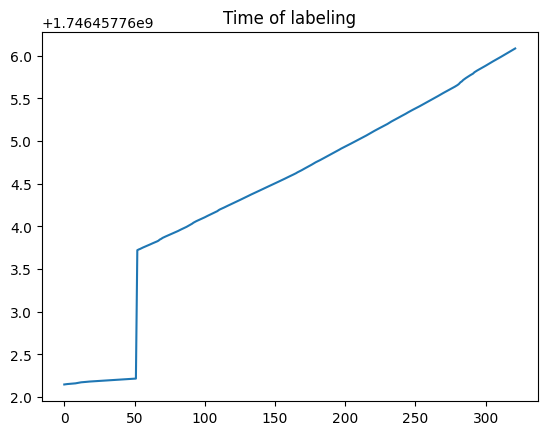

In [11]:
df_results["time"].plot(title="Time of labeling")

By default, the records that are part of the prior knowledge are included in the results. To obtain the labels use the following code:

In [12]:
df_results["label"]

0      0
1      0
2      0
3      0
4      0
      ..
317    0
318    0
319    0
320    0
321    1
Name: label, Length: 322, dtype: Int64

For normal reviews, the state also contains the ranking of the last iteration of the machine learning model. To get these, use the following code:

In [13]:
with asr.open_state("example.asreview") as state:
    last_ranking = state.get_last_ranking_table()

last_ranking

,record_id,ranking,classifier,querier,balancer,feature_extractor,training_set,time
